In [1]:
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Coordinación por pares

Un modelo de coordinación por pares es un modelo en el que en una población de agentes, cada agente toma a alguno de sus vecinos y juega un juego de coordinación en el que su objetivo es tomar la misma decisión que su oponente.

Descripción del modelo
- En un primer encuentro, los agentes inventan una estrategia. 
- En cada encuentro, los agentes almacenan en su memoria las estrategias que observan de los otros jugadores.
- En cada nuevo juego, los jugadores eligen aleatoriamente de entre todas las estrategias que pueden observar en memoria.
- Si en algún juego los agentes coordinan en una de sus estrategias, esos agentes borran su vector de memoria y conservan únicamente la estrategia en la que coordinaron.

Este tipo de juegos describen cómo surgen convenciones en una sociedad. Por ejemplo, los agentes podrían estar aprendiendo a saludarse entre sí. Cada vez que se encuentran con una persona, inventan un saludo, que es o bien levantar el dedo pulgar, mostrar la palma de la mano y moverla de lado a lado, o dar un apretón de manos. 

Lo interesante de los modelos es que, si bien ninguno de los agentes tiene la pretensión de instituir una forma particular de saludarse, sin embargo algunas formas de saludarse terminan por establecerse como convenciones en toda la sociedad.

A su vez, es muy relevante la red subyacente sobre la cual los agentes se comunican. Dependiendo de la topología de esa red, las convenciones se difundirán más o menos rápido, o no se difundirán en absoluto.

<hr>

### work in progress

Lo próximo a hacer es mejorar la visualización de las redes. Un punto importante en algunas redes es que, en vez de formarse un consenso absoluto entre todos los agentes, se generan "vecindarios" en donde el subconjunto de agentes de ese vecindario mantienen una misma convención, pero que es diferente a las de otros vecindarios. Esto podría visualizarse bien coloreando los nodos de un grafo según la estrategia que utilizan. También podría buscarse alguna métrica que lo describiera.

In [26]:
class Player:
    def __init__(self, name):
        self.name = name
        self.memory_vector = [np.random.randint(1,4)]
        self.success = 0
    
    def add_strategy(self, strategy):
        self.memory_vector.append(strategy)
        
    def erase_memory(self):
        self.memory_vector = []

        
class CoordinationGame:
    def __init__(self, player_1, player_2):
        self.player_1 = player_1
        self.player_2 = player_2
        self.players = [player_1, player_2]
        
    def play(self):
        player_1_strat = np.random.choice(self.player_1.memory_vector)
        player_2_strat = np.random.choice(self.player_2.memory_vector)
        
        if player_1_strat == player_2_strat:
            for player in self.players:
                player.erase_memory()
                player.add_strategy(player_1_strat)
                player.success = 1
        else:
            if player_2_strat not in self.player_1.memory_vector:
                self.player_1.add_strategy(player_2_strat)
            else:
                pass
            if player_1_strat not in self.player_2.memory_vector:
                self.player_2.add_strategy(player_1_strat)
            else:
                pass
            self.player_1.success = 0
            self.player_2.success = 0

In [27]:
class Simulation:
    def __init__(self, players, rounds):
        self.players = players
        self.rounds = rounds
        self.successes = []
        self.last_round = 0
    
    def update_successes(self):
        self.successes.append(sum([player.success for player in self.players]))
        
    def cycle(self):
        for i, player in enumerate(self.players):
            other_player = np.random.choice([x for j,x in enumerate(self.players) if j != i])
            game = CoordinationGame(player, other_player)
            game.play()
        self.update_successes()
        
    def go(self):
        for i in tqdm(list(range(self.rounds))):
            self.cycle()
            
            last_round = i
            
            if self.successes == len(self.players):
                break
            
    def plot_successes(self):
        data = go.Scatter(
            x=list(range(1,self.rounds+1)),
            y=self.successes
        )

        layout = go.Layout(
            title='Éxitos en la coordinación por ciclos de la simulación',
            xaxis_title='Ticks',
            yaxis_title='Éxitos',
            template='plotly_dark'
        )

        fig = go.Figure(data=data, layout=layout)
        py.offline.iplot(fig)

## Test del juego

En este primer test no voy a suponer ninguna red subyacente, sino que voy a loopear por todos los agentes y que elijan algún compañero al azar

- Con 500 agentes el juego se hizo demasiado largo, pero de todos modos los resultados fueron malos
- Con 100 agentes fue mucho más rápido. Los resultados: igual de malos. A ver qué pasa si pruebo con más ciclos de la simulación.

In [28]:
players = [Player(num) for num in list(range(1,100))]
rounds = 500
sim = Simulation(players, rounds)
sim.go()

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.46it/s]


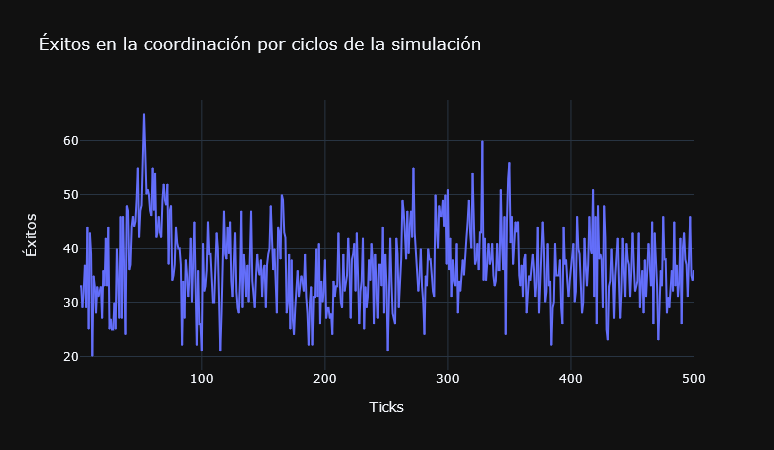

In [5]:
sim.plot_successes()

## Primera conclusión

Después de haber corrido la simulación unas pares de veces, aproximadamente la mitad de esas veces los agentes llegan a un consenso y la mitad no. Curiosamente, las veces que sí llegaron a un consenso lo hicieron en alrededor 200 ciclos de la simulación. Pero en cualquier caso, parecería que la simulación está andando relativamente bien.

Próximo paso: empezar a probar la simulación considerando la red de comunicación que vincule a todos los agentes, y probar distintas topologías de red.

<hr>

# Juego sobre redes

Para poder correr la simulación con agentes a los que subyace una red, hay que cambiar un poco la clase ```Simulation```.

<hr>

In [197]:
class Simulation:
    def __init__(self, players, network, rounds):
        self.network = network
        nx.set_node_attributes(self.network, players, 'jugador')
        self.players = [self.network.nodes[node]['jugador'] for node in self.network.nodes]
        self.rounds = rounds
        self.successes = []
        self.last_round = 0
    
    def update_successes(self):
        self.successes.append(sum([player.success for player in self.players]))
        
    def setup(self):
        self.successes = []
        self.last_round = 0
        for player in self.players:
            player.erase_memory()
            player.memory_vector = [np.random.randint(1,4)]
        
    def include_social_movement(self, n_players):
        starters = np.random.choice(self.players, n_players, replace=False)
        for starter in starters:
            starter.erase_memory()
            starter.memory_vector = [5]
    
    def cycle(self):
        for node in self.network:
            player = self.network.nodes[node]['jugador']
            other_player = self.network.nodes[np.random.choice(list(self.network.neighbors(node)))]['jugador']
            game = CoordinationGame(player, other_player)
            game.play()
        self.update_successes()
        
    def go(self, v=True):
        iterator = range(self.rounds)
        for i in (tqdm(iterator) if v else iterator):
            self.cycle()
            
            last_round = i
            
            if self.successes == len(self.players):
                break
        
    def _reached_stability(self):
        player_strats = [player.memory_vector for player in self.players]
        if player_strats.count(player_strats[0])  == len(player_strats):
            return 1
        else:
            return 0
            
    def plot_successes(self):
        data = go.Scatter(
            x=list(range(1,self.rounds+1)),
            y=self.successes
        )

        layout = go.Layout(
            title='Éxitos en la coordinación por ciclos de la simulación',
            xaxis_title='Ticks',
            yaxis_title='Éxitos',
            template='plotly_dark'
        )

        fig = go.Figure(data=data, layout=layout)
        py.offline.iplot(fig)
        
    def plot_network(self):
        kwargs = {'width':0.2, 'node_size':50, 'with_labels':False, "node_color":"red"}#
        plt.figure(figsize=(10,7))
        nx.draw_kamada_kawai(self.network, **kwargs)
        plt.show()
        

def setup_watts_strogatz(n, k, p, rounds):
    players = {num:Player(num) for num in list(range(n))}
    network = nx.watts_strogatz_graph(n, k, p)
    return Simulation(players, network, rounds)

def setup_random_network(n, p, rounds):
    players = {num:Player(num) for num in list(range(n))}
    network = nx.erdos_renyi_graph(n, p)
    return Simulation(players, network, rounds)
        
        
def test_sim(n_tests, sim, with_social_movement=False, starters=None):
    sim_stabilized = []
    for n_test in tqdm(range(n_tests)):
        sim.setup()
        if with_social_movement:
            sim.include_social_movement(starters)
        sim.go(v=False)
        sim_stabilized.append(sim._reached_stability())
    return sim_stabilized

Con estos cambios, ya puedo empezar a probar distintas estructuras de red.

### Red Watts Strogatz

El modelo [Watts Strogatz](https://es.wikipedia.org/wiki/Modelo_Watts_y_Strogatz) se suele utilizar para construir redes de mundo pequeño. Toma tres parámetros
- $n$: la cantidad de nodos
- $k$: cantidad de vecinos por nodo
- $p$ probabilidad de nuevas conexiones con vecinos lejanos

Cuando $p=0$, la red resultante es una red en anillo con $k$ vecinos para cada nodo.

In [193]:
np.random.choice([1,2,3,5,6,7,8,9,10,11,12,13],12, replace=False)

array([10,  6,  9, 13, 11, 12,  3,  5,  8,  2,  7,  1])

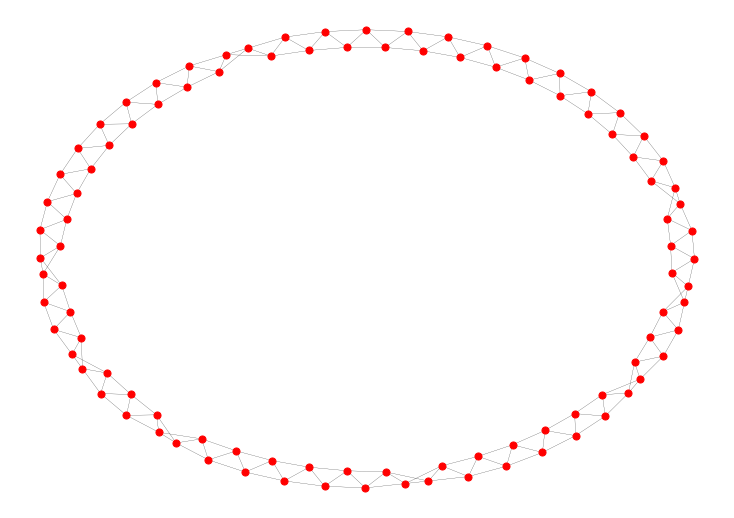

In [163]:
n_players = 100
k = 4
p = 0
players = {num:Player(num) for num in list(range(n_players))}
network = nx.watts_strogatz_graph(n_players, k, p)
sim = Simulation(players, network, 500)
sim.plot_network()

# for player in np.random.choice(sim.players, 50):
#     player.memory_vector = [1]

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 506.40it/s]


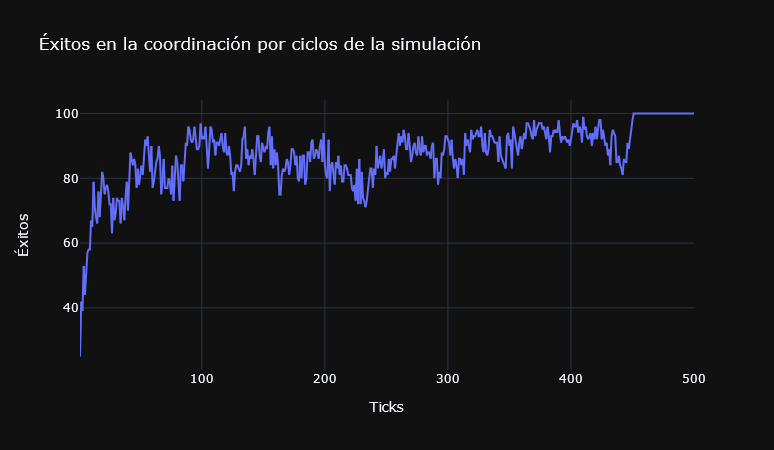

In [171]:
sim.setup()
sim.include_social_movement(10)
sim.go()
sim.plot_successes()

In [172]:
sim.players[0].memory_vector

[1]

Con este tipo de red, para 500 iteraciones de la simulación, los agentes suelen no llegar a un consenso. Muy probablemente tenga que ver con el hecho de que, dado que cada nodo tiene un grado bajo, se forman "vecindarios" entre los cuales hay consensos locales, pero que no alcanzan a difundirse por toda la red. Acá es donde sería importante tener un gráfico coloreado de la red para observar en qué estrategias se van estabilizando los agentes

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.01it/s]


In [114]:
sim_stabilized

[1, 1]

<hr>

### Watts Strogatz con p > 0 pero bajo

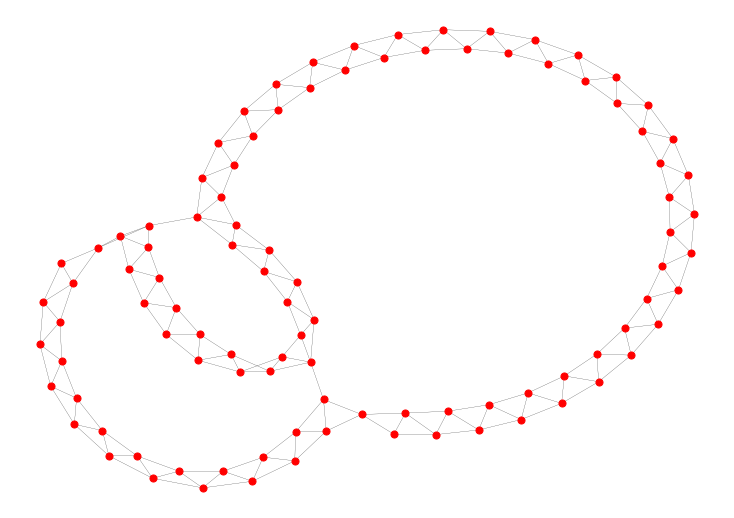

In [227]:
n_players = 100
k = 4
p = 0.01
players = {num:Player(num) for num in list(range(n_players))}
network = nx.watts_strogatz_graph(n_players, k, p)
sim = Simulation(players, network, 500)
sim.plot_network()

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 190.73it/s]


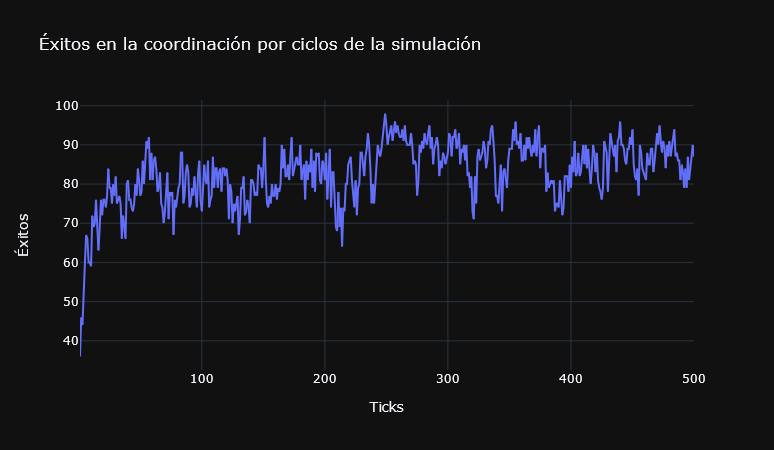

In [228]:
sim.go()
sim.plot_successes()

Corrí pocas vueltas con esta red, pero en todas los agentes llegaron a un consenso. Mayor conectividad parece llevar a consensos más rápidos

<hr>

### Watts Strogatz con p > 0 pero alto

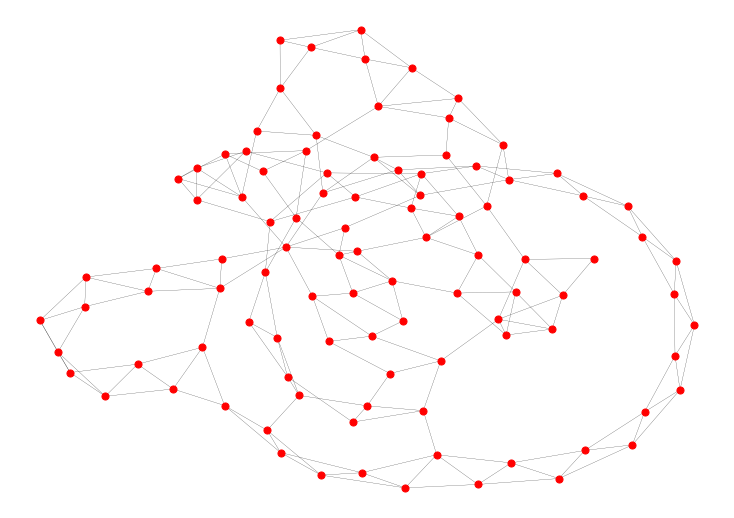

In [149]:
n_players = 100
k = 4
p = 0.1
players = {num:Player(num) for num in list(range(n_players))}
network = nx.watts_strogatz_graph(n_players, k, p)
sim = Simulation(players, network, 500)
sim.plot_network()

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 472.33it/s]


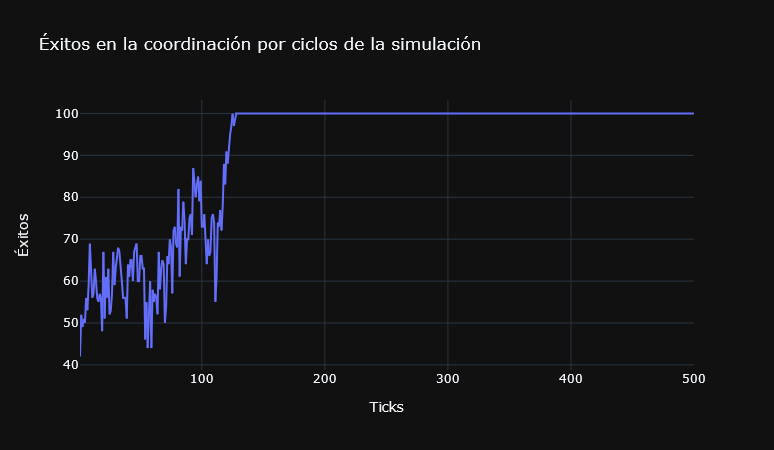

In [150]:
sim.go()
sim.plot_successes()

Dado que los nodos están poco *clusterizados*, no se produce un solapamiento de los vecindarios y por eso los agentes tardan más en producir un comportamiento de rebaño. Sin embargo, terminan formando consensos casi siempre

<hr>

### Red aleatoria

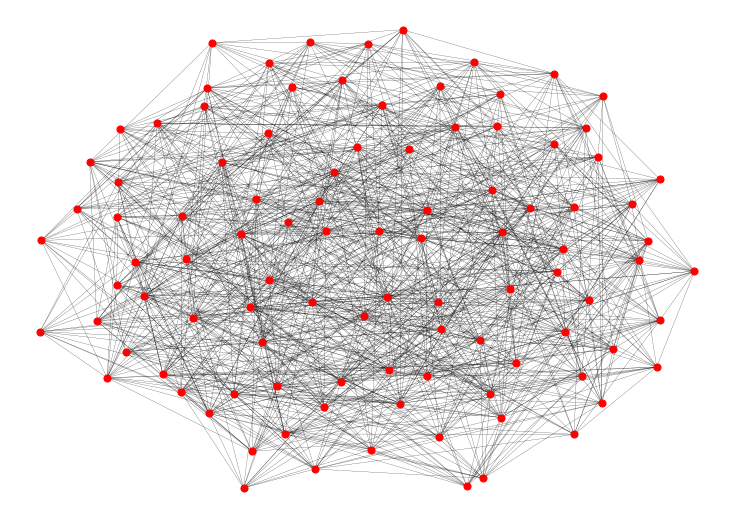

In [68]:
n_players = 100
players = {num:Player(num) for num in list(range(n_players))}
network = nx.erdos_renyi_graph(n_players, 0.2)
sim = Simulation(players, network, 1000)
sim.plot_network()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 466.79it/s]


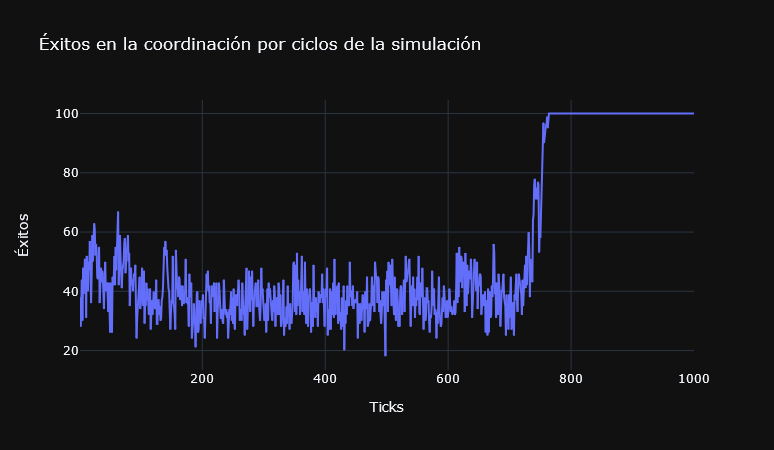

In [69]:
sim.go()
sim.plot_successes()

In [74]:
sim._reached_stability()

True

De la mayoría de las pruebas que hice, en ninguna se alcanzó un consenso.

Hasta ahora probé cuatro setups de redes:
- Red Watts Strogatz con p = 0: tarda bastante en llegar a un consenso, antes se forman pequeños vecindarios que se "pelean" entre ellos
- Red Watts Strogatz con p > 0 pero bajo: tarda un poquito menos
- Red Watts Strogatz con p > 0 pero alto: tarda bastante menos
- Red aleatoria: la probé con probabilidad de conectividad relativamente baja. Por lo general se mantiene durante un tiempo con poca cantidad de éxitos hasta que empieza un fenómeno tipo cascada y todos adoptan el comportamiento.

In [207]:
n_tests = 20

## Red en anillo

In [208]:
ring = {'nombre': 'red en anillo'}

In [209]:
stabilized_ring = test_sim(n_tests, setup_watts_strogatz(100, 4, 0, 500))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.95s/it]


In [210]:
ring.update({'no_starters':sum(stabilized_ring)/n_tests})

In [211]:
for n_starters in [20,30,40,50]:
    sabilized_ring_starters = test_sim(n_tests, setup_watts_strogatz(100, 4, 0, 500), True, n_starters)
    ring.update({f'{n_starters} starters': sum(sabilized_ring_starters)/n_tests})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.13s/it]


## Red en anillo con conexiones lejanas

In [212]:
ring_long_ties = {'nombre': 'anillo con conexiones lejanas'}

In [213]:
stabilized_ring_long_ties = test_sim(n_tests, setup_watts_strogatz(100, 4, 0.01, 500))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.16s/it]


In [214]:
ring_long_ties.update({'no_starters':sum(stabilized_ring_long_ties)/n_tests})

In [215]:
for n_starters in [20,30,40,50]:
    stabilized_ring_long_ties_starters = test_sim(n_tests, setup_watts_strogatz(100, 4, 0.01, 500), True, n_starters)
    ring_long_ties.update({f'{n_starters} starters': sum(stabilized_ring_long_ties_starters)/n_tests})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.52s/it]


## Cuasi aleatoria

In [216]:
quasi_random = {'nombre': 'cuasi-aleatoria'}

In [217]:
stabilized_quasi_random = test_sim(n_tests, setup_watts_strogatz(100, 4, 0.1, 500))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.31s/it]


In [218]:
quasi_random.update({'no_starters':sum(stabilized_quasi_random)/n_tests})

In [219]:
for n_starters in [20,30,40,50]:
    stabilized_quasi_random_starters = test_sim(n_tests, setup_watts_strogatz(100, 4, 0.1, 500), True, n_starters)
    quasi_random.update({f'{n_starters} starters': sum(stabilized_quasi_random_starters)/n_tests})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.45s/it]


## Aleatoria

In [220]:
random = {'nombre': 'aleatoria'}

In [221]:
stabilized_random = test_sim(n_tests, setup_random_network(100,0.2,500))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it]


In [222]:
random.update({'no_starters':sum(stabilized_random)/n_tests})

In [223]:
for n_starters in [20,30,40,50]:
    stabilized_random_starters = test_sim(n_tests, setup_random_network(100,0.2,500), True, n_starters)
    random.update({f'{n_starters} starters': sum(stabilized_random_starters)/n_tests})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]


---

In [229]:
import pandas as pd

In [226]:
pd.DataFrame([ring, ring_long_ties, quasi_random, random])

,nombre,no_starters,20 starters,30 starters,40 starters,50 starters
0,red en anillo,0.50,0.35,0.55,0.45,0.60
1,anillo con conexiones lejanas,0.65,0.25,0.35,0.45,0.55
2,cuasi-aleatoria,0.75,0.75,0.85,0.75,0.80
3,aleatoria,0.25,0.05,0.00,0.05,0.05
